In [1]:
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utils import (
    COIN_DETAILS_FILE_PATH,
    TRAIN_TARGETS_PARQUET_FILE_PATH,
    COINMARKETCAP_API_KEY, 
    SAMPLE_SYMBOLS,
    human_readable_format)

pd.set_option('future.no_silent_downcasting', True)

TRAIN_START_DATE updated to: 2020-06-01, TRAIN_END_DATE updated to: 2024-07-05


In [2]:
headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': COINMARKETCAP_API_KEY,
}

base_url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/'

# Function to fetch cryptocurrency info from CoinMarketCap
def get_coin_info(symbol):
    url = base_url + 'info'
    params = {'symbol': symbol}
    try:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 400:
            print(f"Coin Info: Bad request for symbol: {symbol} - Skipping retry")
            return None, 400
        response.raise_for_status()
        data = response.json()
        
        coin_data = data['data'][symbol]
        # print(coin_data)
        
        coin_info = {
            'name': coin_data['name'],
            'infinite_supply': coin_data['infinite_supply'],
            'source_code': coin_data['urls']['source_code'][0] if 'urls' in coin_data and 'source_code' in coin_data['urls'] and coin_data['urls']['source_code'] else None
        }   
        return coin_info, 200
    
    except requests.exceptions.RequestException as e:
        print(f"Request failed for symbol: {symbol} - {e}")
        return None, 0


# Function to get coin metrics
def get_coin_metrics(symbol):
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest"
    parameters = {
        'symbol': symbol,
        'convert': 'USD'
    }
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': COINMARKETCAP_API_KEY,
    }

    try:
        response = requests.get(url, headers=headers, params=parameters)
        if response.status_code == 400:
            print(f"Coin Metrics: Bad request for symbol: {symbol} - Skipping retry")
            return None, 400
    
        data = response.json()

        # Extract market cap, total supply, circulating supply
        coin_metrics = {
            'market_cap': data['data'][symbol]['quote']['USD']['market_cap'],
            'total_supply': data['data'][symbol]['total_supply'],
            'circulating_supply': data['data'][symbol]['circulating_supply'],
            'infinite_supply': data['data'][symbol]['total_supply'] is None,
            'is_active': data['data'][symbol]['is_active']
        }   
        return coin_metrics, 200

    except requests.exceptions.RequestException as e:
            print(f"Coin Metrics failed for symbol: {symbol} - {e}")
            return None, 0

def fetch_coin_info_with_retry(symbol, retries=2, delay=60):
    for attempt in range(retries):
        try:
            # Fetch basic coin info
            coin_info, status_code = get_coin_info(symbol)
            
            if status_code == 400:
                # Skip retry if status code is 400
                return None
            if coin_info is None:
                raise ValueError(f"Failed to fetch basic info for {symbol}")

            # Fetch detailed metrics
            print(f'Fetching coin metrics for: {symbol}')
            coin_metrics, status_code = get_coin_metrics(symbol)

            if status_code == 400:
                # Skip retry if status code is 400
                return None
            if coin_metrics is None:
                raise ValueError(f"Failed to fetch coin metrics for {symbol}")
            
            return {
                'symbol': symbol,
                'name': coin_info['name'],
                'total_supply': coin_metrics['total_supply'],
                'circulating_supply': coin_metrics['circulating_supply'],
                'market_cap': coin_metrics['market_cap'],
                'infinite_supply': coin_info['infinite_supply'],
                'is_active': coin_metrics['is_active'],
                'source_code': coin_info['source_code'],
            }
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

            if attempt < retries - 1:
                time.sleep(delay)
            else:
                return {
                    'symbol': symbol,
                    'name': None,
                    'total_supply': None,
                    'circulating_supply': None,
                    'market_cap': None,
                    'infinite_supply': None,
                    'is_active': None,
                    'source_code': None
                }


In [3]:
train_df = pd.read_parquet(TRAIN_TARGETS_PARQUET_FILE_PATH)

# Load existing data if the file exists
if os.path.exists(COIN_DETAILS_FILE_PATH):
    existing_data = pd.read_csv(COIN_DETAILS_FILE_PATH)
else:
    existing_data = pd.DataFrame(columns=['symbol', 'name'])

# Extract unique symbols from your dataset
unique_symbols = train_df['symbol'].unique()

# Identify symbols for which names are missing
existing_symbols_downloaded = existing_data[~existing_data['name'].isna() & (existing_data['name'] != '')]['symbol']
missing_symbols = set(unique_symbols) - set(existing_symbols_downloaded)

# Convert the pandas series to a set
existing_symbols_with_names_set = set(existing_symbols_downloaded)

# Print the number of elements in each set
print(f"Number of unique symbols in train_df: {len(unique_symbols)}")
print(f"Number of symbols in existing_data with data: {len(existing_symbols_with_names_set)}")
print(f"Number of missing symbols: {len(missing_symbols)}")

# # Optional: Print the actual sets for debugging
print(f"Unique symbols in train_df: {set(unique_symbols)}")
print(f"Symbols in existing_data with names: {existing_symbols_with_names_set}")
print(f"Missing symbols: {missing_symbols}")

# Loop through missing symbols and fetch their information with rate limiting
# requests_made = 0
# request_limit = 30
request_window = 60  # seconds

for symbol in missing_symbols:
    # if requests_made >= request_limit:
    #     print(f"Reached {request_limit} requests, sleeping for {request_window} seconds.")
    #     time.sleep(request_window)
    #     requests_made = 0

    coin_info = fetch_coin_info_with_retry(symbol)
    # requests_made += 1
    
    if coin_info:
        coin_details = {
            'symbol': coin_info['symbol'],
            'name': coin_info['name'],
            'circulating_supply': coin_info['circulating_supply'],
            'total_supply': coin_info['total_supply'],
            'market_cap': coin_info['market_cap'],
            'infinite_supply': coin_info['infinite_supply'],
            'is_active': coin_info['is_active'],
            'source_code': coin_info['source_code'],
            'is_open_source': coin_info['source_code'] is not None
        }
    else:
        coin_details = {'symbol': symbol, 'name': None, 'circulating_supply': None}
    
    # Convert the new entry to DataFrame
    new_coin_details_df = pd.DataFrame([coin_details])

    # Concatenate with existing data
    updated_data = pd.concat([existing_data, new_coin_details_df], ignore_index=True)
    
    # Save the updated DataFrame to CSV incrementally
    updated_data.to_csv(COIN_DETAILS_FILE_PATH, index=False)
    
    # Update existing_data to include the newly fetched details
    existing_data = updated_data

# Display the final updated DataFrame
# updated_data.head()


Number of unique symbols in train_df: 1439
Number of symbols in existing_data with data: 1439
Number of missing symbols: 0
Unique symbols in train_df: {'CRU', 'STOS', '1EARTH', 'HARD', 'GRIN', 'NAKA', 'CENNZ', 'KEX', 'ROOM', 'CELL', 'TOP', 'GFI', 'IOTX', 'APY', 'PHNX', 'NSBT', 'GZONE', 'SOCKS', 'TOKO', 'OAS', 'DEXE', 'DIGG', 'NAFT', 'NYZO', 'KRIPTO', 'WMT', 'SFD', 'AQT', 'DAG', 'MYRA', 'SAND', 'LRC', 'STRONG', 'GARD', 'TURBO', 'GEL', 'SUN', 'LNR', 'WHALE', 'GET', 'AURA', 'WOM', 'RKN', 'HEX', 'LEASH', 'ZEC', 'SANTOS', 'DVF', 'CRE', 'GTH', 'ROG', 'EDU', 'KROM', 'PROM', 'SENSO', 'H2O', 'STT', 'MARSH', 'TFUEL', 'CGO', 'ZLW', 'RVF', 'FTT', 'RAZOR', 'ARDX', 'BSCPAD', 'XWC', 'SSG', 'BF', 'XEC', 'ARIX', 'SIX', 'XAS', 'BEAM', 'EGLD', 'TLM', 'SERO', 'MNW', 'BTCST', 'ETC', 'HERO', 'HOOK', 'XWG', 'EFX', 'DOGGY', 'ZIL', 'ACA', 'IGU', 'HC', 'SHI', 'TOMI', 'UBXS', 'AMP', 'DIMO', 'KUJI', 'CATCH', 'JADE', 'CUBE', 'AERGO', 'SOLVE', '1UP', 'POLA', 'ACE', 'TORN', 'DAO', 'LUA', 'PLASTIK', 'UMB', 'PPT', 'BI

In [4]:
df = pd.read_csv(COIN_DETAILS_FILE_PATH)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

desired_order = ['symbol', 'name', 'keywords', 'total_supply', 'circulating_supply', 'market_cap', 'infinite_supply', 'is_open_source', 'source_code', 'is_active']
df = df[desired_order]

# Drop non downloaded rows
df = df.dropna(subset=['name'])

# Convert 'infinite_supply' to numeric values
df['infinite_supply'] = df['infinite_supply'].fillna(0).astype(int)
df['infinite_supply'] = df['infinite_supply'].astype(int)

# Convert 'is_open_source' to numeric values
df['is_open_source'] = df['is_open_source'].fillna(0).astype(int)
df['is_open_source'] = df['is_open_source'].astype(int)

# Convert 'is_active' to numeric values
df['is_active'] = df['is_active'].fillna(0).astype(int)
df['is_active'] = df['is_active'].astype(int)

df = df.fillna({
    'circulating_supply': 0,
    'total_supply': 0,
    'market_cap': 0,
    'is_active': 0,
    'source_code': '',
    'name': '',
    'keywords': ''
})

df.to_csv(COIN_DETAILS_FILE_PATH, index=False)

df.head()


,symbol,name,keywords,total_supply,circulating_supply,market_cap,infinite_supply,is_open_source,source_code,is_active
0,NEO,Neo,Neo,1.000000e+08,7.053883e+07,6.519431e+08,0,1,https://github.com/neo-project/neo,1
1,FARA,FaraLand,FaraLand,9.993007e+07,2.292868e+07,2.747674e+05,0,0,,1
2,ALI,Artificial Liquid Intelligence,Artificial Liquid Intelligence,9.872434e+09,6.180790e+09,5.150974e+07,0,1,https://github.com/AI-Protocol-Official,1
3,HONEY,Hivemapper,Hivemapper,6.342243e+09,2.314560e+09,1.603704e+08,0,1,https://github.com/hivemapper,1
4,STRAX,Stratis [New],Stratis coin,1.951821e+09,1.951815e+09,8.607623e+07,1,1,https://github.com/stratisproject,1


In [5]:
df.shape[0]

1439

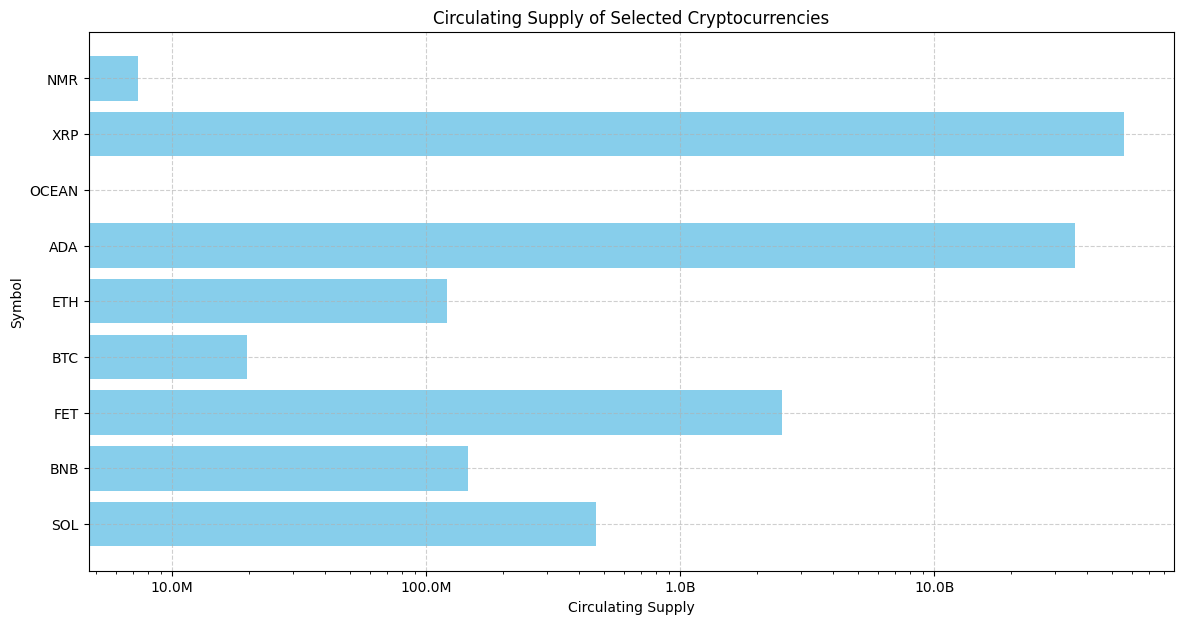

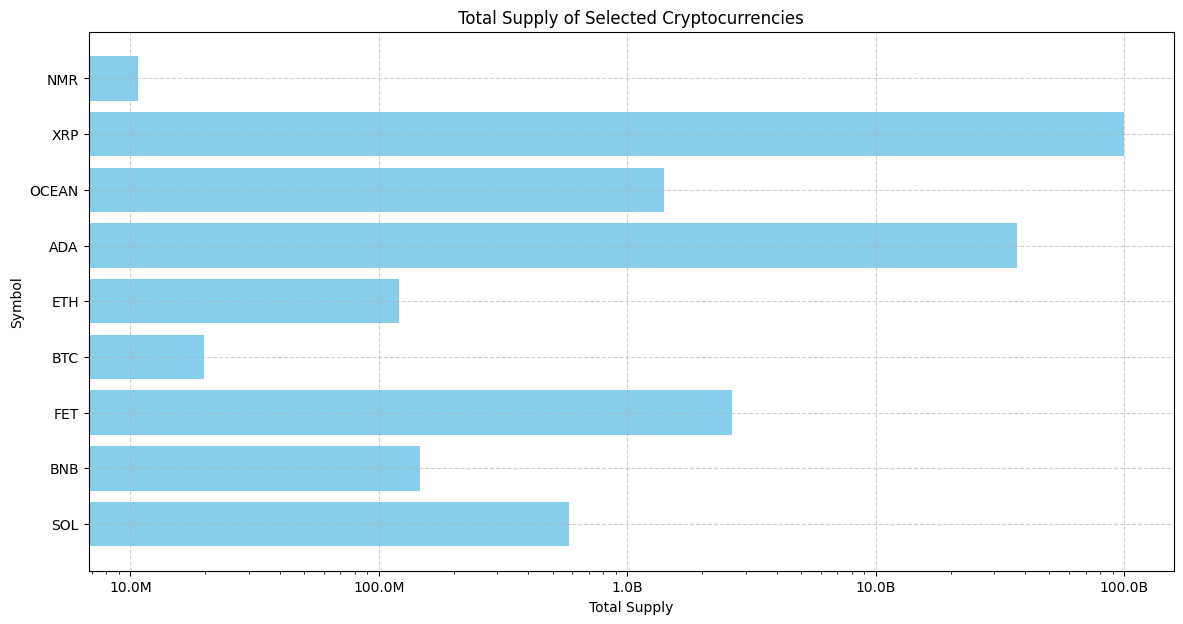

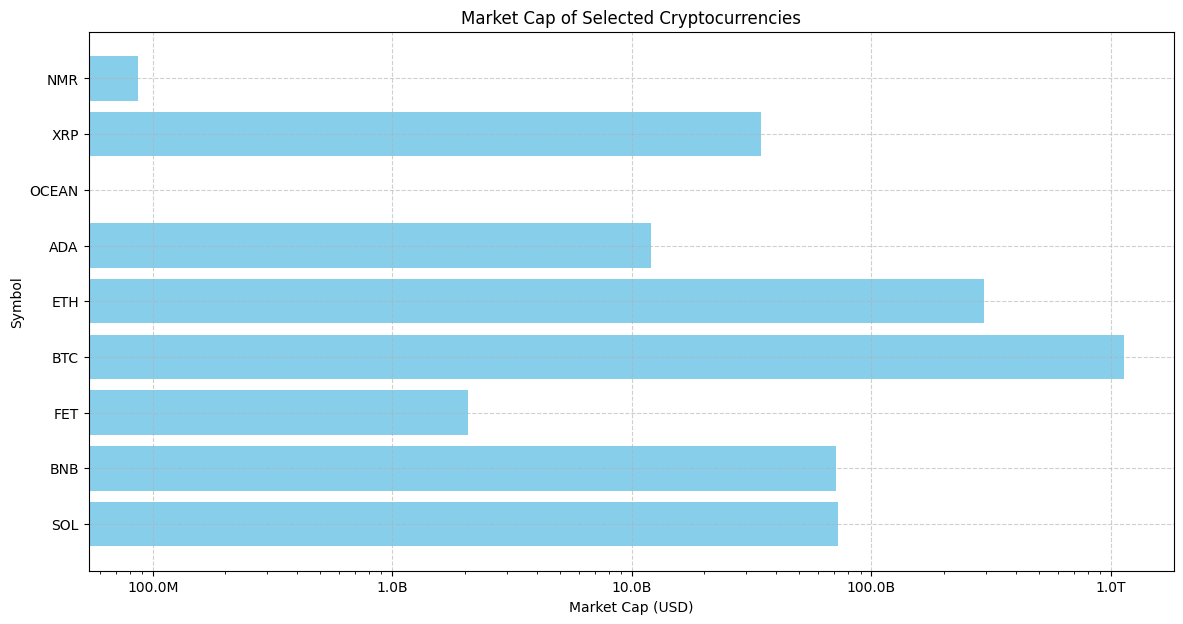

In [6]:
df = pd.read_csv(COIN_DETAILS_FILE_PATH)

# Plot settings
plt.rcParams.update({'figure.figsize': (14, 7), 'axes.grid': True, 'grid.linestyle': '--', 'grid.alpha': 0.6})

def plot_bar(df, column, title, xlabel):
    plt.figure()
    plt.barh(df['symbol'], df[column], color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel('Symbol')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

# Filter the DataFrame for selected symbols
df_filtered = df[df["symbol"].isin(SAMPLE_SYMBOLS)]

# Plot circulating supply
plot_bar(df_filtered, "circulating_supply", "Circulating Supply of Selected Cryptocurrencies", "Circulating Supply")

# Plot total supply
plot_bar(df_filtered, "total_supply", "Total Supply of Selected Cryptocurrencies", "Total Supply")

# Plot market cap
plot_bar(df_filtered, "market_cap", "Market Cap of Selected Cryptocurrencies", "Market Cap (USD)")

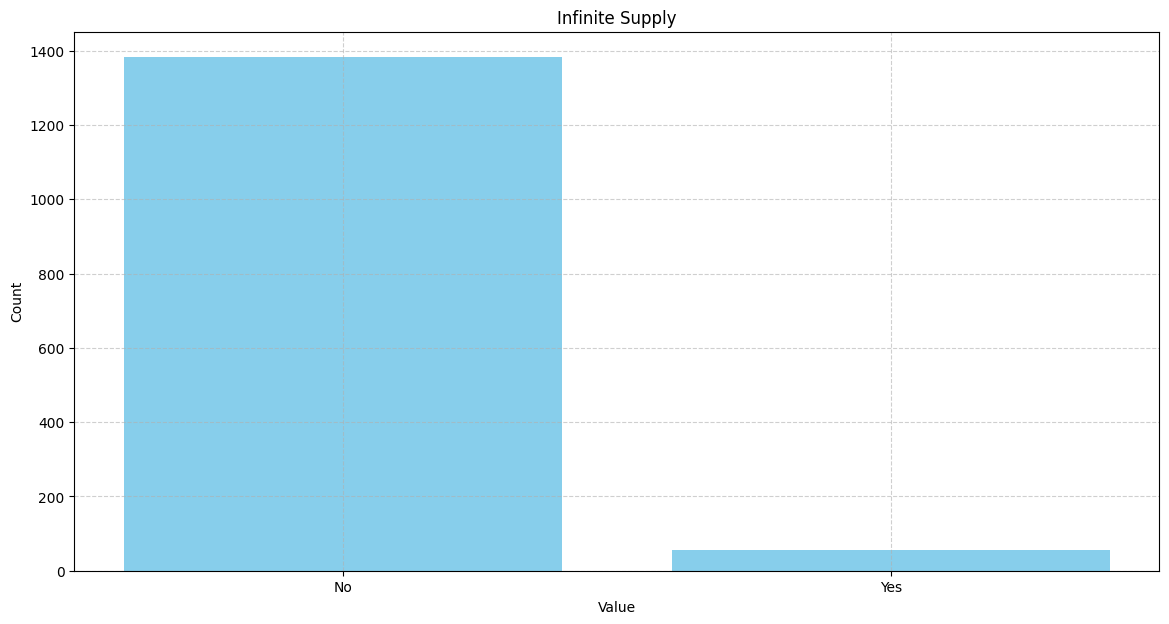

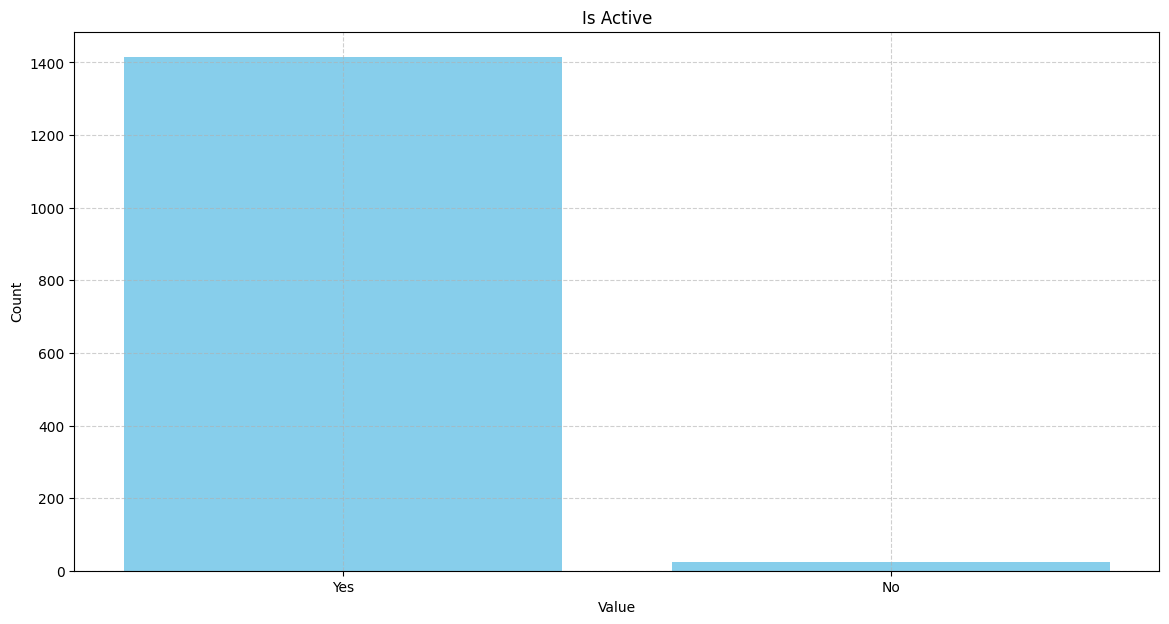

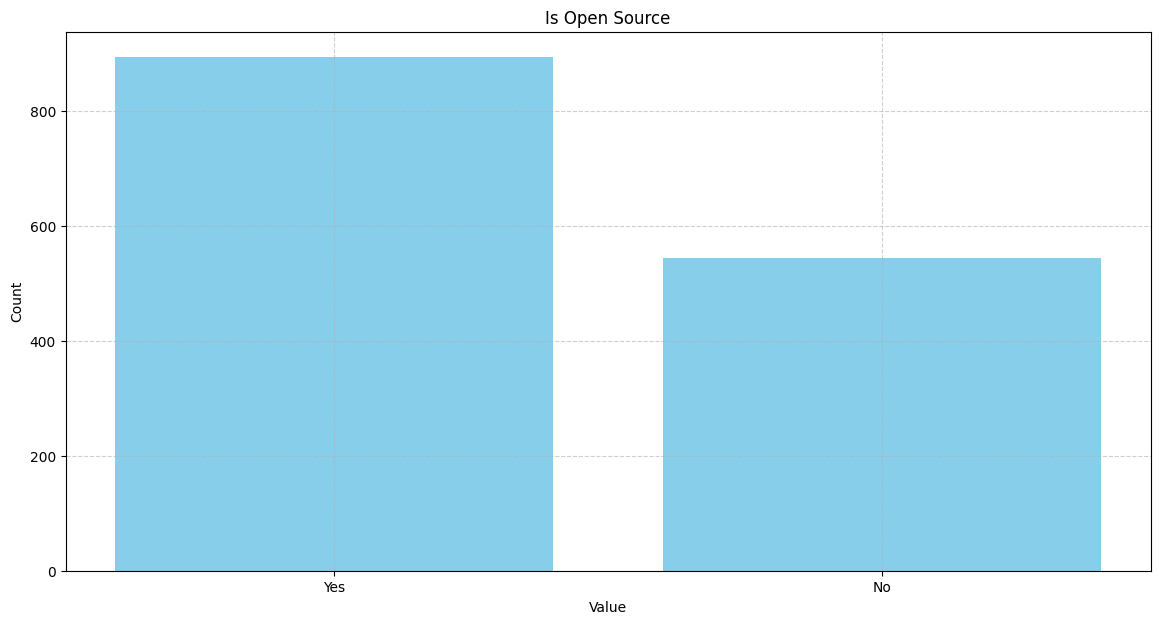

: 

In [7]:
# Plot binary features: infinite_supply, is_active, is_open_source
def plot_binary_feature(df, column, title):
    plt.figure()
    counts = df[column].value_counts()
    plt.bar(counts.index.map({0: 'No', 1: 'Yes'}), counts.values, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(title)

plot_binary_feature(df, "infinite_supply", "Infinite Supply")
plot_binary_feature(df, "is_active", "Is Active")
plot_binary_feature(df, "is_open_source", "Is Open Source")

# Show plots
plt.show()